# Demo workshop

1. <a href="#getdata">Data acquisition and preparation</a>
1. <a href="#runalgo">Run the learning algorithm(s)</a>
1. <a href="#">Visualization of learning efficiency</a>

<a id="getdata"></a>
### Data acquisition and preparation

First we acquire the famous <a href="https://archive.ics.uci.edu/ml/datasets/iris">Iris Data Set</a> due to R.A. Fisher, included in the UCI Machine Learning Respository. We shall store the data in a directory called `data`.

In [1]:
! mkdir data
! mkdir data/iris

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data -P data/iris/
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names -P data/iris/

--2019-01-07 16:25:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [text/plain]
Saving to: ‘data/iris/iris.data’

iris.data           100%[===================>]   4.44K  --.-KB/s    in 0s      

2019-01-07 16:25:44 (118 MB/s) - ‘data/iris/iris.data’ saved [4551/4551]

--2019-01-07 16:25:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2998 (2.9K) [text/plain]
Saving to: ‘data/iris/iris.names’

iris.names          100%[===================>]   2.93K  --.-KB/s    in 0s      

2019-01-07 16:25:4

In [3]:
! ls data/iris

iris.data  iris.names


Next we organize a few basic facts about the dataset, chiefly for clerical purposes.

In [4]:
# Clerical stuff.
NUM_DATA = 150
NUM_TRAIN = 100 # Set manually.
NUM_TEST = NUM_DATA - NUM_TRAIN
NUM_FEATURES = 4
NUM_CLASSES = 3
NUM_LABELS = 1
LABEL_DICT = {"Iris-setosa": 0,
              "Iris-versicolor": 1,
              "Iris-virginica": 2}

Beware that this `iris.data` file contains one more line than is required (since there should be only 150 points). The 151st line is blank, and so we can just skip it.

In [5]:
! wc -l data/iris/iris.data

151 data/iris/iris.data


Next we use the `csv` module to read the text file and convert the data into a `numpy` array.

In [6]:
import os
import csv
import numpy as np

toread = os.path.join("data", "iris", "iris.data")

data_X = np.zeros((NUM_DATA,NUM_FEATURES), dtype=np.float32)
data_y = np.zeros((NUM_DATA,1), dtype=np.int8)

with open(toread, newline="") as f_table:
    
    f_reader = csv.reader(f_table, delimiter=",")
    
    i = 0
    for line in f_reader:
        data_X[i,:] = np.array(line[0:-1],
                               dtype=data_X.dtype)
        data_y[i,:] = np.array(LABEL_DICT[line[-1]],
                               dtype=data_y.dtype)
        i += 1
        
        if i >= NUM_DATA: # to skip the final blank line.
            break
        

Finally, as a simple bit of pre-processing, we normalize the inputs in a per-feature manner.

In [7]:
maxvec = np.max(data_X, axis=0) # vector of maxes
minvec = np.min(data_X, axis=0) # vector of mins
data_X = data_X-minvec
with np.errstate(divide="ignore", invalid="ignore"):
    data_X = data_X / (maxvec-minvec)
    data_X[data_X == np.inf] = 0
    data_X = np.nan_to_num(data_X)

<a id="runalgo"></a>
### Run the learning algorithm(s)

The details of the learning algorithm are as follows.

The new estimator makes use of a new influence function, of the following form.

\begin{align*}
\psi(u) =
\begin{cases}
u - u^{3}/6, & -\sqrt{2} \leq u \leq \sqrt{2}\\
2\sqrt{2}/3, & u > \sqrt{2}\\
-2\sqrt{2}/3, & u < -\sqrt{2}.
\end{cases}
\end{align*}

The new estimator is defined as follows. Given $\psi$ as above, and $d$-dimensional observations $x_{1},\ldots,x_{n} \in \mathbb{R}^{d}$, we define an estimator of the *inner product* of an independent copy of $x$ and $\theta \in \mathbb{R}^{d}$ on the unit circle, i.e., $\|\theta\|=1$, as

\begin{align*}
\widehat{e}(\theta) = \int \left(\frac{s}{n} \sum_{i=1}^{n} \psi\left(\frac{\langle \theta^{\prime}, x_{i} \rangle}{s}\right) \right) \, d\nu_{\theta}(\theta^{\prime}).
\end{align*}

Note that this is an estimator; it depends on the $n$-sized independent random sample, but it is also taking expectation with respect to a "noisy" parameter $\theta^{\prime}$. Here $\nu_{\theta} = \mathcal{N}(\theta,\beta^{-1}I_{d})$ is a $d$-dimensional isotropic Gaussian distribution, with variance parameter $\beta > 0$.

We have modified notation slightly: in their paper, they use $\lambda$, defined as

\begin{align*}
\lambda = \frac{1}{s}.
\end{align*}

Fortunately, in the case of Gaussian $\nu_{\theta}$, the estimator can be computed extremely easily, in "closed form" up to use of Gaussian CDFs. Its computation is done as follows. First, we must note that for $W \sim \mathcal{N}(0,1)$, we can compute

\begin{align*}
\varphi(m,\sigma) & = \mathbf{E}\,\psi(m+W\sigma)\\
& = m \left( 1-\frac{\sigma^{2}}{2}\right) - \frac{m^{3}}{6} + r(m,\sigma),
\end{align*}

where $r(m,\sigma)$ is a correction term that is tedious but straightforward to compute. Plugging this identity in to the definition of $\widehat{e}(\theta)$, we can easily compute the new estimator.

What remains is setting the parameters $\lambda$ and $\beta$. The proposed settings in Proposition 3.3 are as follows. Let $T$ and $v$ be upper bounds on second moments such that

\begin{align*}
\mathbf{E}\,\|x\|^{2} & \leq T < \infty\\
\sup_{\|\theta\|=1} \mathbf{E}\,\langle \theta, x \rangle^{2} & \leq v \leq T < \infty.
\end{align*}

Then the parameters should be set as

\begin{align*}
\lambda & = \sqrt{\frac{2\log(\delta^{-1})}{nv}}\\
\beta & = \sqrt{nT} \lambda = \sqrt{\frac{2T\log(\delta^{-1})}{v}}.
\end{align*}

With these "oracle" settings, the nice guarantee provided, with no less than $1-\delta$ probability, is that

\begin{align*}
\sup_{\|\theta\|=1} \left| \widehat{e}(\theta) - \langle \theta, \mathbf{E}\,x \rangle \right| \leq \sqrt{\frac{T}{n}} + \sqrt{\frac{2v\log(\delta^{-1})}{n}}.
\end{align*}

Our approach is to apply the one-dimensional version of the above robust estimation procedure as a sub-routine in an otherwise traditional steepest descent optimization procedure.

Below, we test this algorithm using `data_X` and `data_y` prepared above, we proceed with a simple proof of concept experiment. We run the following algorithms:

- `shallow`: linear combination of the inputs, no hidden layers.
- `deep`: non-linear combination of the inputs, with two hidden layers, each with 20 units, and ReLU activation.
- `shallow-rob`: robustified version of `shallow`
- `deep-rob`: robustifier version of `deep`, with the parameters in the final layer being updated robustly, and the rest as normal.

For each trial, from the 150 data points in the full data set, a random subset of $n=100$ is selected for training, and the rest a treated as a sample. This is repeated for all trials.

In [8]:
import chainer as ch
import get_model as gm
import helpers as hlp
import robustify as rob
import config

In [9]:
# Prepare a results directory.
task_name = "iris"
towrite = os.path.join("results", task_name)
hlp.makedir_safe(dirname=towrite)

In [10]:
# Model/algorithm parameters (more in config.py).
t_max = 5*NUM_TRAIN # number of iterations for main routine.
t_init = t_max // 5 # number of iterations for intializer.
num_trials = 25 # number of independent random trials.
num_records = 100+1 # number of times to record performance.
todiv = t_max // (num_records-1)
lr = 0.3 # learning rate; pre-fixed step size iterative updates.

In [11]:
# Main loop over model names.

mod_names = ["shallow", "deep", "shallow-rob", "deep-rob"]

for mod_name in mod_names:
    
    print("Working on:", mod_name, "...", end=" ")

    # Prepare storage for performance metrics.
    loss_tr = np.zeros((num_trials,num_records), dtype=np.float32)
    loss_te = np.zeros((num_trials,num_records), dtype=np.float32)
    costs = np.zeros((num_trials,num_records), dtype=np.float32)

    # Get a random train/test set for each trial.
    for tri in range(num_trials):
        
        cost_counter = 0

        shufidx = np.random.choice(NUM_DATA,
                                   size=NUM_DATA,
                                   replace=False)
        X_tr = data_X[shufidx[0:NUM_TRAIN],:]
        y_tr = data_y[shufidx[0:NUM_TRAIN],:]
        X_te = data_X[shufidx[NUM_TRAIN:],:]
        y_te = data_y[shufidx[NUM_TRAIN:],:]

        nc = NUM_CLASSES # number of classes
        nf = NUM_FEATURES # number of features

        # Preparation of model and optimizer objects.
        mod_init, mod = gm.get_model(mod_name=mod_name, nf=nf, nc=nc)
        opt_init = ch.optimizers.SGD(lr=lr)
        opt = ch.optimizers.SGD(lr=lr)
        opt_init.setup(mod_init)
        opt.setup(mod)

        # Next prepare the initializer models.
        tval = 0
        idx = 0
        while tval < t_init:

            # Evaluate current state.
            loss_init = ch.functions.softmax_cross_entropy(
                x=mod_init(X_tr),
                t=y_tr.flatten(),
                normalize=True,
                reduce="mean"
            )

            # Cost updates.
            cost_counter += X_tr.shape[0]

            # Get gradients.
            mod_init.cleargrads()
            loss_init.backward()

            # Parameter updates.
            opt_init.update()

            tval += 1


        # Next, copy the initialized parameters.
        mod.copyparams(mod_init)

        # Finally, run the learning algorithm for the initialized models.
        tval = 0
        while tval < t_max:

            # Evaluate current state.
            loss = ch.functions.softmax_cross_entropy(
                x=mod(X_tr),
                t=y_tr.flatten(),
                normalize=True,
                reduce="mean"
            )

            # Get gradients.
            mod.cleargrads()
            loss.backward()

            # Parameter updates.
            opt.update()

            # Cost updates.
            cost_counter += X_tr.shape[0]

            # Record performance for the given iteration and given trial.
            if tval % todiv == 0:
                loss_tr[tri,idx] = 1.0-ch.functions.accuracy(
                    y=mod(X_tr),
                    t=y_tr.flatten()
                ).data
                loss_te[tri,idx] = 1.0-ch.functions.accuracy(
                    y=mod(X_te),
                    t=y_te.flatten()
                ).data
                costs[tri,idx] = cost_counter
                idx += 1

            tval += 1

        # Record final performance if not done so already.
        if idx < num_records:
            loss_tr[tri,idx] = 1.0-ch.functions.accuracy(
                    y=mod(X_tr),
                    t=y_tr.flatten()
                ).data
            loss_te[tri,idx] = 1.0-ch.functions.accuracy(
                    y=mod(X_te),
                    t=y_te.flatten()
                ).data
            costs[tri,idx] = cost_counter
            idx += 1

    # After running all trials, take stats and arrange into perf mtx.
    ave_loss_tr = np.mean(loss_tr, axis=0)
    ave_loss_te = np.mean(loss_te, axis=0)
    ave_loss = np.vstack((ave_loss_tr,ave_loss_te)).T # transpose it.
    ave_cost = np.mean(costs, axis=0)

    # Write to disk.
    np.savetxt(fname=os.path.join(towrite, (mod_name+".ave")),
               X=ave_loss, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (mod_name+".cost")),
               X=ave_cost, fmt="%.7e", delimiter=",")
    
    del mod_init, opt_init, mod, opt
    
    print("Done.")

Working on: shallow ... Done.
Working on: deep ... Done.
Working on: shallow-rob ... Done.
Working on: deep-rob ... Done.


<a id="performance"></a>
### Visualization of learning efficiency

Having run the experiments given above, here we prepare some simple plots of training/testing error, given as a function of the number of gradients computed. This works as a natural metric for *learning efficiency*, namely the performance achieved per unit of computational resources.

The *error* computed is misclassification rate, computed for the training set and testing set. The values shown are averaged over all independent trials.

In [12]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [13]:
# Clerical material.
task_name = "iris"
toread = os.path.join("results", task_name)

methods_shallow = ["shallow", "shallow-rob"]
methods_deep = ["deep", "deep-rob"]

colours = ["black", "blue"]
linestyles = ["-", "-"]
labels = ["GD", "RGD (ours)"]

FONTSIZE = "x-large"

#### In-sample training error

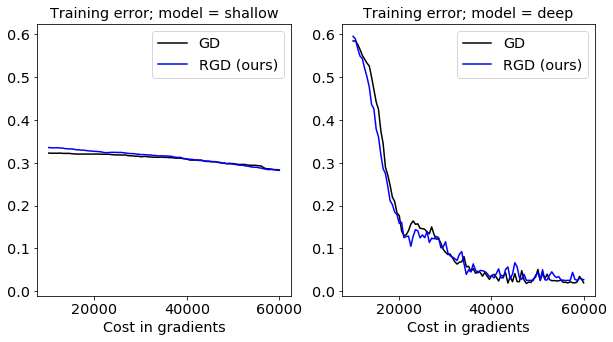

In [14]:
myfig = plt.figure(figsize=(10,5))
perf_idx = 0

ax1 = myfig.add_subplot(1,2,1)
todo_methods = methods_shallow
for i in range(len(todo_methods)):
    
    al_name = todo_methods[i]
    al_colour = colours[i]
    al_linestyle = linestyles[i]
    al_label = labels[i]
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (al_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    with open(os.path.join(toread, (al_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    ax1.plot(tmp_cost, tmp_ave[:,perf_idx], linestyle=al_linestyle, color=al_colour, label=al_label)
    ax1.tick_params(labelsize=FONTSIZE)

ax1.legend(loc=1,ncol=1, fontsize=FONTSIZE)
plt.title("Training error; model = shallow", size=FONTSIZE)
plt.xlabel("Cost in gradients", size=FONTSIZE)

ax2 = myfig.add_subplot(1,2,2, sharey=ax1)
todo_methods = methods_deep
for i in range(len(todo_methods)):
    
    al_name = todo_methods[i]
    al_colour = colours[i]
    al_linestyle = linestyles[i]
    al_label = labels[i]
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (al_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    with open(os.path.join(toread, (al_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    ax2.plot(tmp_cost, tmp_ave[:,perf_idx], linestyle=al_linestyle, color=al_colour, label=al_label)
    ax2.tick_params(labelsize=FONTSIZE)

ax2.legend(loc=1,ncol=1, fontsize=FONTSIZE)
plt.title("Training error; model = deep", size=FONTSIZE)
plt.xlabel("Cost in gradients", size=FONTSIZE)

# Finally, display both the shallow and deep case results.
plt.show()

#### Off-sample testing error

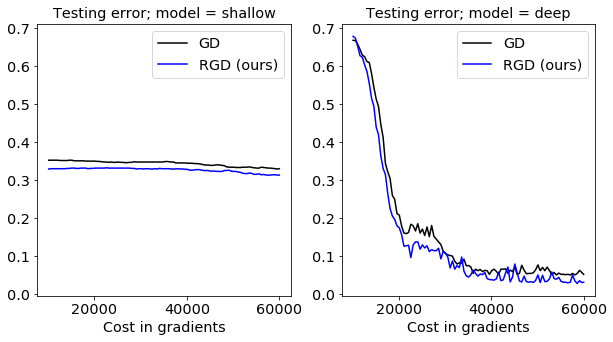

In [15]:
myfig = plt.figure(figsize=(10,5))
perf_idx = 1

ax1 = myfig.add_subplot(1,2,1)
todo_methods = methods_shallow
for i in range(len(todo_methods)):
    
    al_name = todo_methods[i]
    al_colour = colours[i]
    al_linestyle = linestyles[i]
    al_label = labels[i]
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (al_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    with open(os.path.join(toread, (al_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    ax1.plot(tmp_cost, tmp_ave[:,perf_idx], linestyle=al_linestyle, color=al_colour, label=al_label)
    ax1.tick_params(labelsize=FONTSIZE)

ax1.legend(loc=1,ncol=1, fontsize=FONTSIZE)
plt.title("Testing error; model = shallow", size=FONTSIZE)
plt.xlabel("Cost in gradients", size=FONTSIZE)

ax2 = myfig.add_subplot(1,2,2, sharey=ax1)
todo_methods = methods_deep
for i in range(len(todo_methods)):
    
    al_name = todo_methods[i]
    al_colour = colours[i]
    al_linestyle = linestyles[i]
    al_label = labels[i]
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (al_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    with open(os.path.join(toread, (al_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.float, delimiter=",")
        
    ax2.plot(tmp_cost, tmp_ave[:,perf_idx], linestyle=al_linestyle, color=al_colour, label=al_label)
    ax2.tick_params(labelsize=FONTSIZE)

ax2.legend(loc=1,ncol=1, fontsize=FONTSIZE)
plt.title("Testing error; model = deep", size=FONTSIZE)
plt.xlabel("Cost in gradients", size=FONTSIZE)

# Finally, display both the shallow and deep case results.
plt.show()

The main take-away from the above toy example is that even when the data is *not* heavy-tailed, the proposed procedure performs as well or better than GD-based ERM, which is known to be essentially optimal when the data is sub-Gaussian.

___